In [1]:
import wandb

import json
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns

api = wandb.Api()
run = api.run("mlatberkeley/StackedCapsuleAutoEncoders/3fxygvj1")
# dir(run), run.summary.keys(), run.summary.img_predictions, dir(run.summary.img_predictions)

In [2]:
table_file = wandb.restore(run.summary.img_predictions.path, run_path="mlatberkeley/StackedCapsuleAutoEncoders/3fxygvj1")
table_str = table_file.read().replace('{"name": "mnist", "random_translate": false, "random_rotate": false}', '"mnist"')
table_dict = json.loads(table_str)
df = pd.DataFrame(**table_dict)
num_caps = 4
for c in range(num_caps):
    # map thetas to [-pi, pi]
    df[f"c{c}_theta"] = (df[f"c{c}_theta"] + np.pi) % (2*np.pi) - np.pi

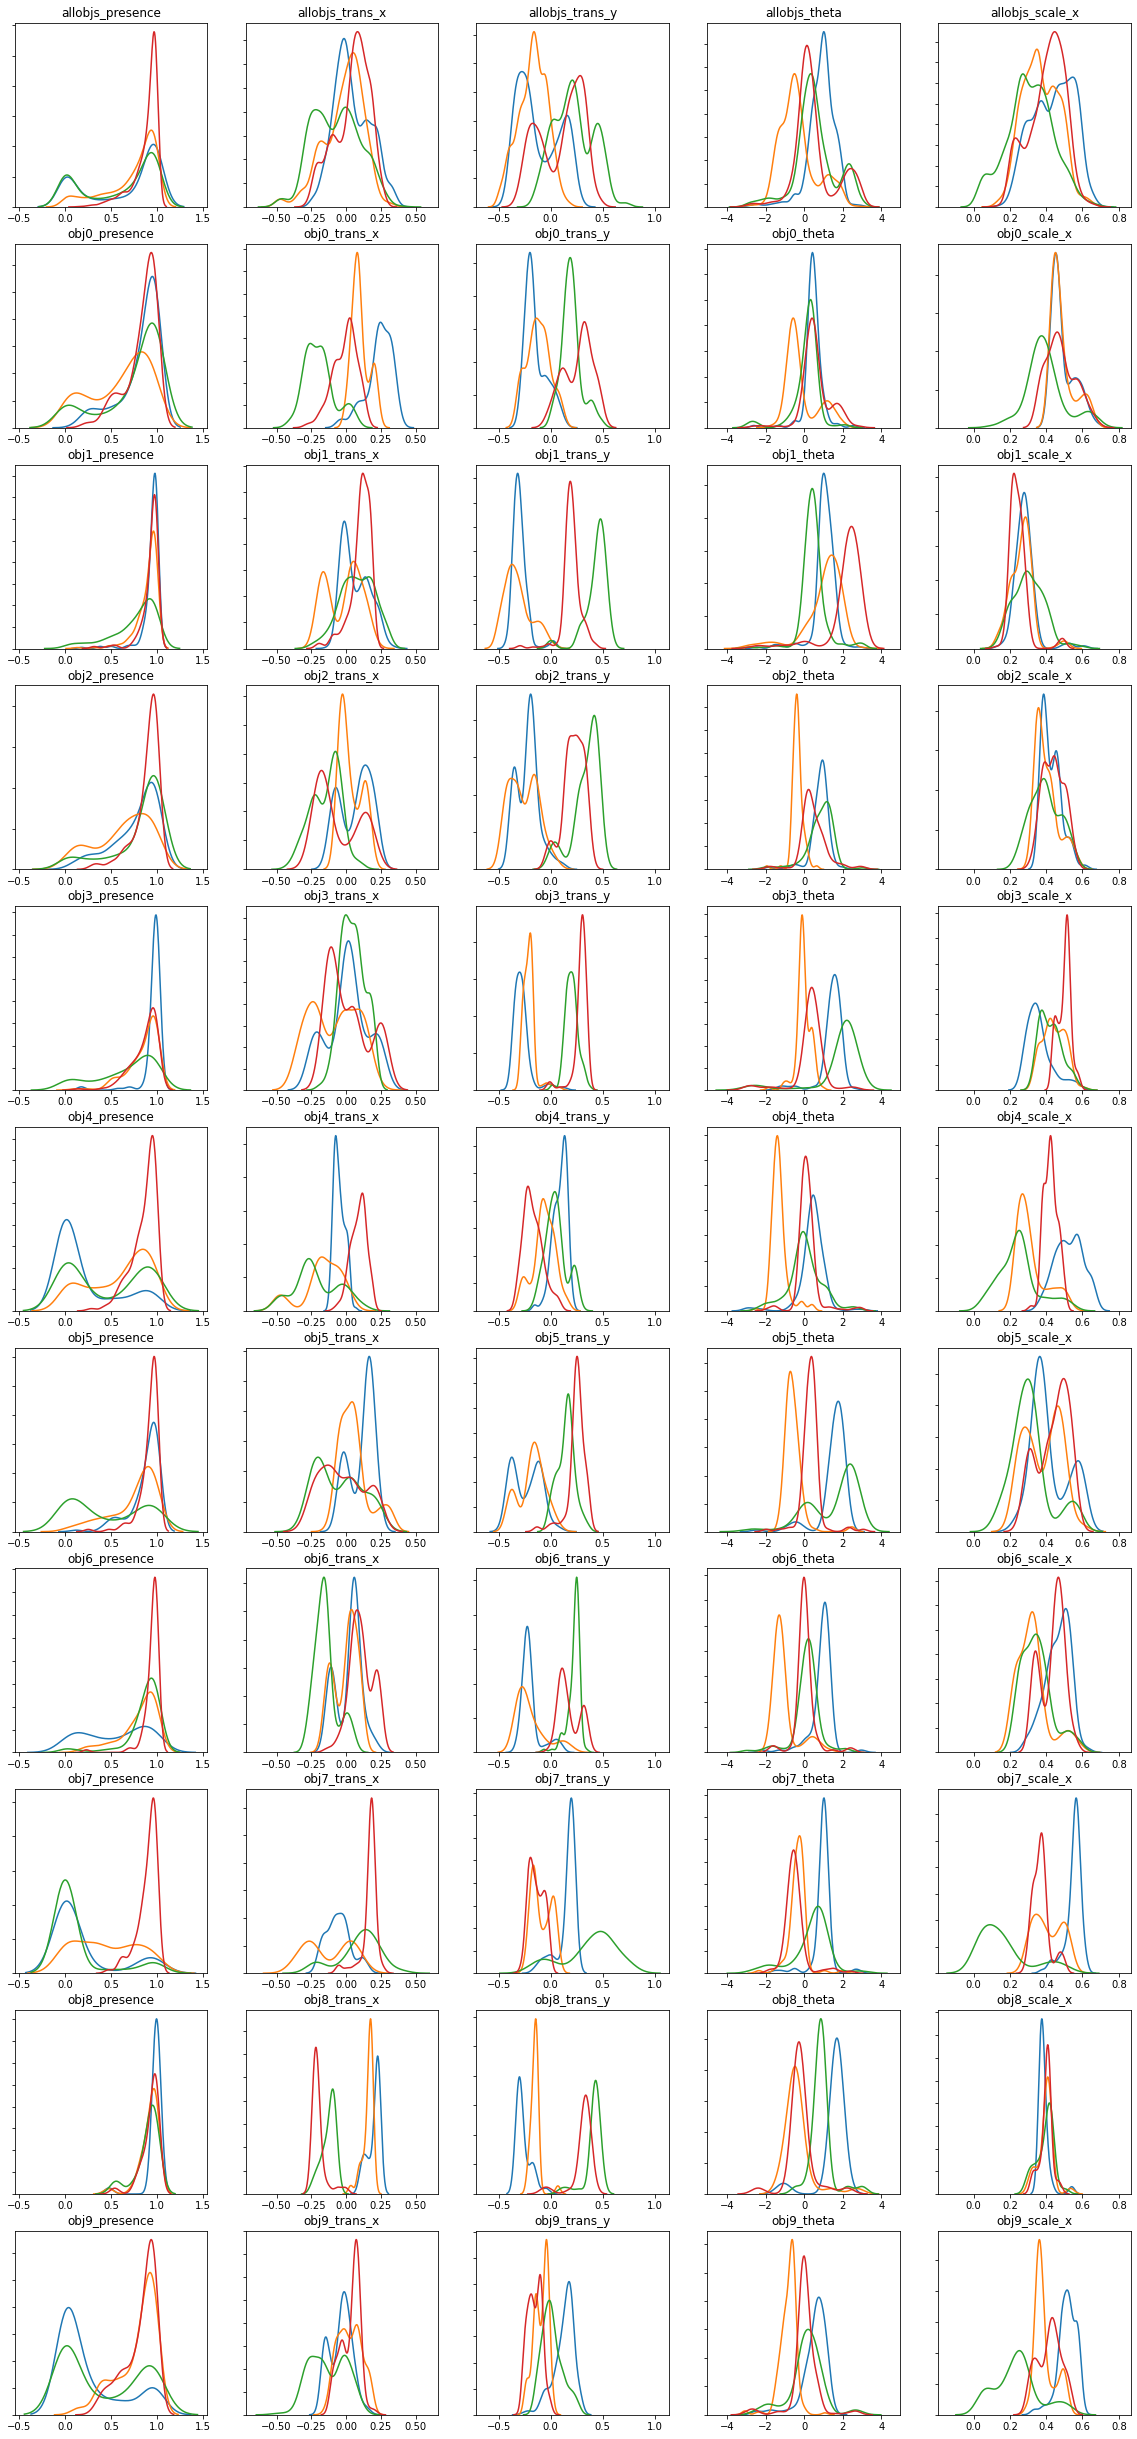

In [3]:
width = 20
# scale_y and shear unused due to similarity constraint
# attrs = ["presence", "trans_x", "trans_y", "theta", "scale_x", "scale_y", "shear"]
attrs = ["presence", "trans_x", "trans_y", "theta", "scale_x"]
num_objs = 10
num_caps = 4
len_y, len_x = num_objs + 1, len(attrs)
fig, ax = plt.subplots(len_y, len_x, figsize=(width, width / len_x * len_y), sharex='col', facecolor='w')
for a, attr in enumerate(attrs):
    for c in range(num_caps):
        col_str = f"c{c}_{attr}"
        sns.kdeplot(df[col_str], ax=ax[0, a])
        ax[0, a].set_title(f"allobjs_{attr}")

        for l in range(num_objs):
            sns.kdeplot(df[df["label"] == l][col_str], ax=ax[l + 1, a])
            ax[l + 1, a].set_title(f"obj{l}_{attr}")

    for l in range(num_objs + 1):
        ax[l, a].set_xlabel("")
        ax[l, a].set_ylabel("")
        ax[l, a].xaxis.set_tick_params(which='both', labelbottom=True)
        plt.setp(ax[l, a].get_yticklabels(), visible=False)

plt.show()

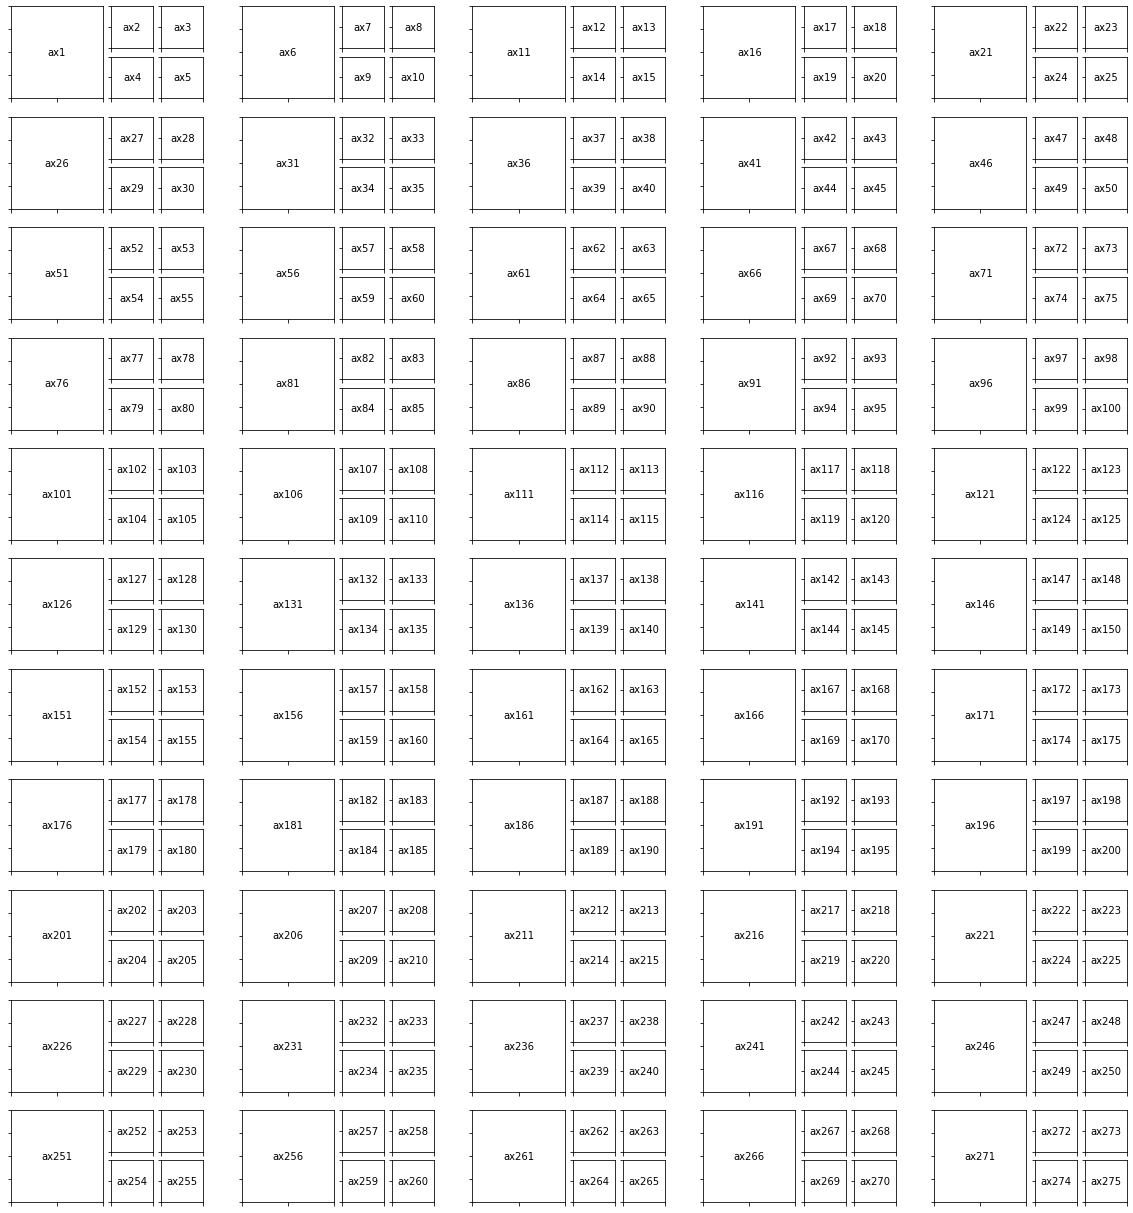

In [4]:
# gridspec inside gridspec
width = 20
len_y, len_x = 11, 5
fig = plt.figure(figsize=(width, width / len_x * len_y / 2), facecolor='w')
ggrid = gridspec.GridSpec(len_y, len_x, figure=fig)

for y in range(len_y):
    for x in range(len_x):
        len_yy, len_xx = 2, 4
        grid = gridspec.GridSpecFromSubplotSpec(len_yy, len_xx, subplot_spec=ggrid[y, x])
        
        ax = fig.add_subplot(grid[:, :2])
        for yy in range(len_yy):
            for xx in range(2, len_xx):
                ax = fig.add_subplot(grid[yy, xx])

# plt.suptitle("GridSpec Inside GridSpec")
for i, ax in enumerate(fig.axes):
    ax.text(0.5, 0.5, "ax%d" % (i+1), va="center", ha="center")
    ax.tick_params(labelbottom=False, labelleft=False)

plt.show()

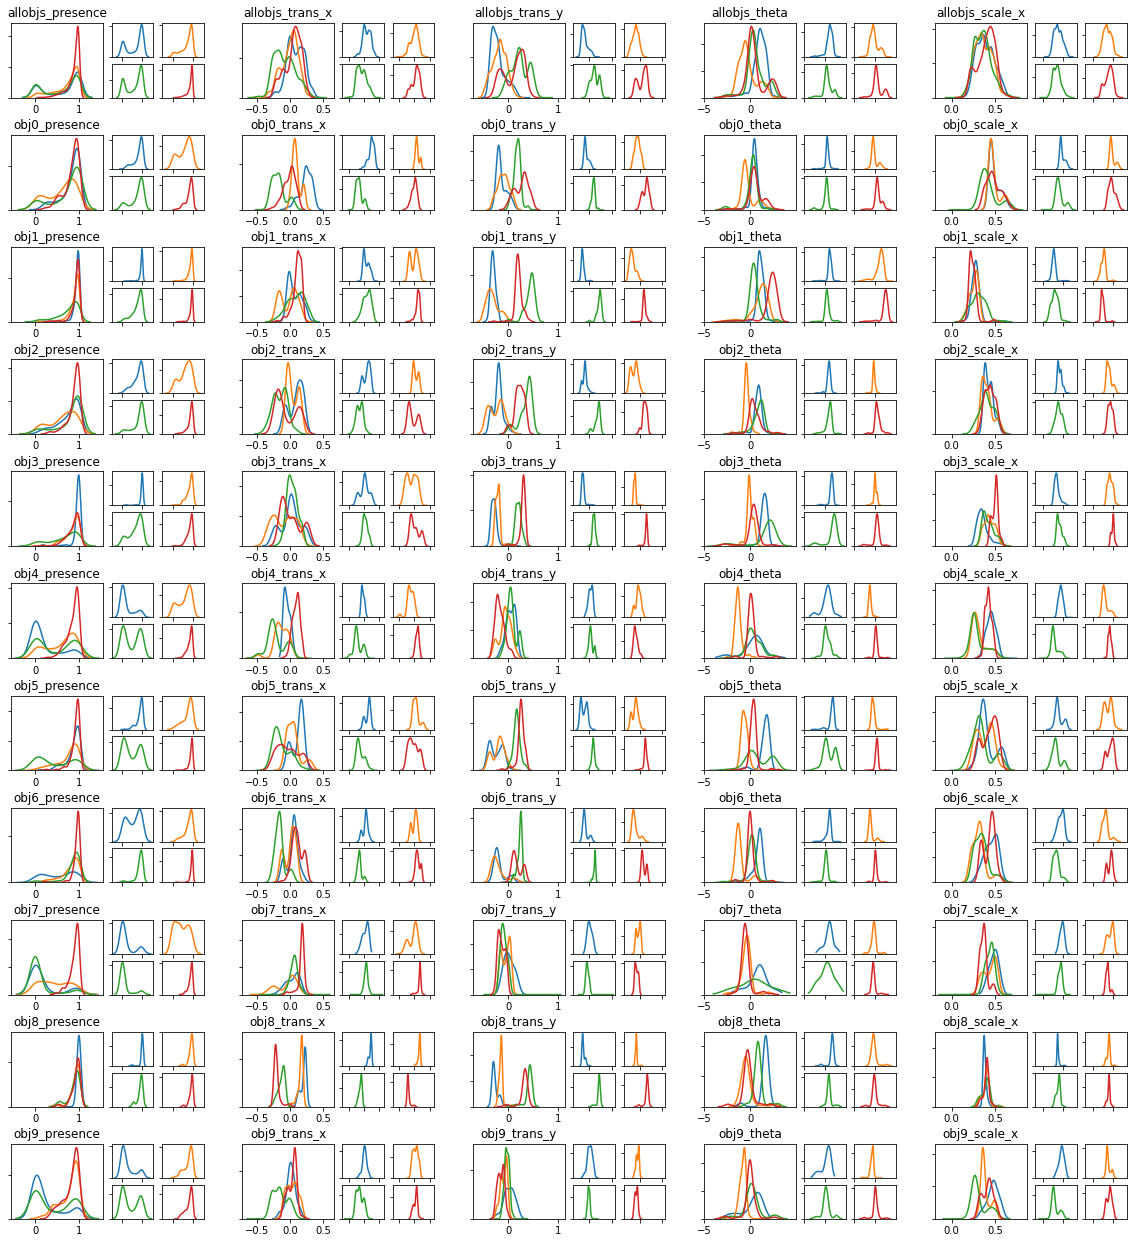

In [5]:
width = 20
# scale_y and shear unused due to similarity constraint
# attrs = ["presence", "trans_x", "trans_y", "theta", "scale_x", "scale_y", "shear"]
attrs = ["presence", "trans_x", "trans_y", "theta", "scale_x"]
num_objs = 10
num_caps = 4
len_y, len_x = num_objs + 1, len(attrs)
fig = plt.figure(figsize=(width, width / len_x * len_y / 2), facecolor='w')
ggrid = gridspec.GridSpec(len_y, len_x, figure=fig, hspace=.5)
colormap = matplotlib.cm.get_cmap('tab10')

for a, attr in enumerate(attrs):
    len_yy, len_xx = 2, 4
    grid_col = [gridspec.GridSpecFromSubplotSpec(len_yy, len_xx, subplot_spec=ggrid[l, a]) for l in range(len_y)]
    first_axs = fig.add_subplot(grid_col[0][:, :2])
    axs_rows = [[first_axs]] + [[fig.add_subplot(grid[:, :2], sharex=first_axs)] for grid in grid_col[1:]]
    
    for row_idx in range(len_y):
        for yy in range(len_yy):
                for xx in range(2, len_xx):
                    ax = fig.add_subplot(grid_col[row_idx][yy, xx], sharex=first_axs)
#                     ax.set_xlabel("")
#                     ax.set_ylabel("")
#                     ax.xaxis.set_tick_params(which='both', labelbottom=False)
                    
                #     ax.xaxis.set_tick_params(which='both', labelbottom=True)
                    plt.setp(ax.get_xticklabels(), visible=False)
                    plt.setp(ax.get_yticklabels(), visible=False)
                    axs_rows[row_idx].append(ax)
    
    for c in range(num_caps):
#         color = colormap(c / (num_caps - 1))
        color = colormap(c / 10)
        col_str = f"c{c}_{attr}"
        
        caps_attr = df[col_str]
        if attr is not "presence":
            caps_presences = df[f"c{c}_presence"]
            sns.kdeplot(caps_attr, weights=caps_presences, ax=axs_rows[0][0], color=color)
            sns.kdeplot(caps_attr, weights=caps_presences, ax=axs_rows[0][c + 1], color=color)
        else:
            sns.kdeplot(caps_attr, ax=axs_rows[0][0], color=color)
            sns.kdeplot(caps_attr, ax=axs_rows[0][c + 1], color=color)
        axs_rows[0][0].set_title(f"allobjs_{attr}")
        
        for l in range(len_y - 1):
            caps_attr_given_l = caps_attr[df["label"] == l]
            
            if attr is not "presence":
                caps_presences_given_l = caps_presences[df["label"] == l]
                sns.kdeplot(caps_attr_given_l, weights=caps_presences_given_l, ax=axs_rows[l + 1][0], color=color)
                sns.kdeplot(caps_attr_given_l, weights=caps_presences_given_l, ax=axs_rows[l + 1][c + 1], color=color)
            else:
                sns.kdeplot(caps_attr_given_l, ax=axs_rows[l + 1][0], color=color)
                sns.kdeplot(caps_attr_given_l, ax=axs_rows[l + 1][c + 1], color=color)
            axs_rows[l + 1][0].set_title(f"obj{l}_{attr}")
            
for i, ax in enumerate(fig.axes):
    ax.set_xlabel("")
    ax.set_ylabel("")
    plt.setp(ax.get_yticklabels(), visible=False)

plt.show()